Para realizar a análise, regressão e classificação, escolhemos o dataset Housing Prices, disponível em:

https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

O dataset é composto por apenas 1 arquivo .csv separado por vírgulas (",")
O arquivo contém 13 colunas, sendo o objetivo realizar a regressão para inferir o preço das casas e realizar a classificação para inferir quais casas possuem sala de visitas.

1) importar as dependências necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2) leitura do arquivo

In [2]:
df = pd.read_csv('Housing.csv', delimiter=',', header=0)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,Nan,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


3) Transformação dos dados de atributos qualitativos para quantitativos e análise descritiva

In [11]:
df_cp = df.copy()
obj_cols = [col for col in df_cp.columns if df_cp[col].dtype == 'object']

le = LabelEncoder()

# para colunas de valor booleano (sim ou não) devem existir apenas 2 tipos de resposta, furnishingstatus deve possuir 3 valores
print(f"Valores repetidos:\n{df[obj_cols].nunique()}")

Valores repetidos:
mainroad            2
guestroom           2
basement            2
hotwaterheating     3
airconditioning     2
prefarea            2
furnishingstatus    3
dtype: int64


In [12]:
# caso exista valores fora do padrão, devem ser substituidos com None
valores_aceitos = ['yes', 'no']
obj_cols_bool = obj_cols.copy()
obj_cols_bool.remove('furnishingstatus')
for col in obj_cols_bool:
    df_cp[col] = df_cp[col].apply(lambda x: x if x in valores_aceitos else None)

valores_furnishingstatus = ['furnished', 'semi-furnished', 'unfurnished']
df_cp['furnishingstatus'] = df_cp['furnishingstatus'].apply(lambda x: x if x in valores_furnishingstatus else None)

print(f"\n\nValores faltantes:\n{df_cp.isnull().sum()}")



Valores faltantes:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     1
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


Valores faltantes:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     1
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


<AxesSubplot:>

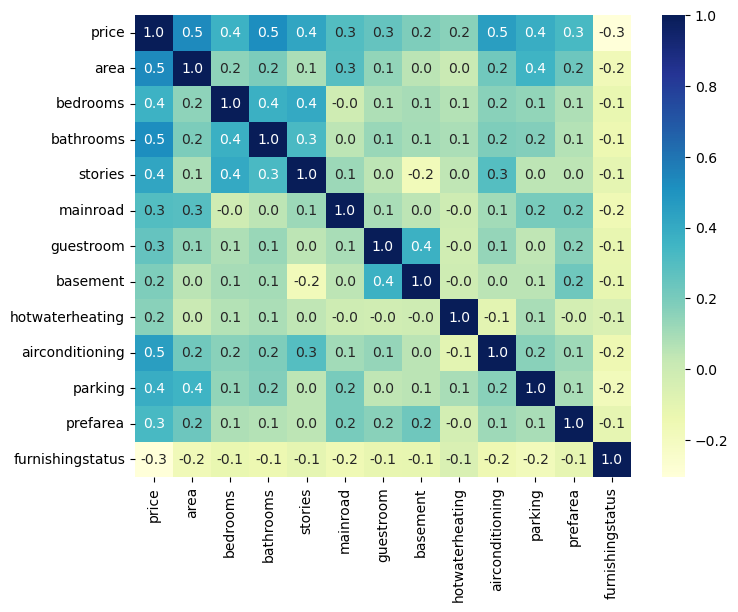

In [13]:
# transformação de dados qualitativos em quantitativos
for col in obj_cols:
  df_cp[col] = le.fit_transform(df_cp[col])

# plot do mapa de calor de correlação
corr = df_cp.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt=".1f")

4) divisão do dataset em conjunto de treinamento e conjunto de teste

In [ ]:
training = df.sample(frac=0.8)
test = df.drop(training.index)

training_price = training['price']
training_guestroom = training['guestroom']

test_price = test['price']
test_guestroom = test['guestroom']

del training['price']
del training['guestroom']

del test['price']
del test['guestroom']